In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
data_train = pd.read_csv("train_loan.csv")
data_test = pd.read_csv("test_loan.csv")

In [4]:
data_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
data_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
print("Training data size: ", data_train.shape)
print("Test data size: ", data_test.shape)

Training data size:  (614, 13)
Test data size:  (367, 12)


In [7]:
data_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
data_test.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,367.000000,367.000000,362.000000,361.000000,338.000000
mean,4805.599455,1569.577657,136.132597,342.537396,0.825444
std,4910.685399,2334.232099,61.366652,65.156643,0.380150
min,0.000000,0.000000,28.000000,6.000000,0.000000
25%,2864.000000,0.000000,100.250000,360.000000,1.000000
50%,3786.000000,1025.000000,125.000000,360.000000,1.000000
75%,5060.000000,2430.500000,158.000000,360.000000,1.000000
max,72529.000000,24000.000000,550.000000,480.000000,1.000000


In [9]:
print("Training data info ", data_train.info())
print("Test data info ", data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
Training data info  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (t

In [10]:
tr_num = data_train.select_dtypes(include = ["int64", "float64"]).columns.tolist()
tr_cat = data_train.select_dtypes(include = ["object"]).columns.tolist()
print("Numerical features in training data are: ", tr_num)
print("Categorical features in training data are: ", tr_cat)
df_train_num = data_train[tr_num]
df_train_cat = data_train[tr_cat]

Numerical features in training data are:  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical features in training data are:  ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


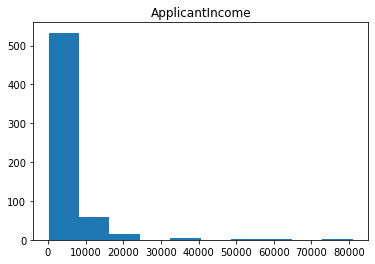

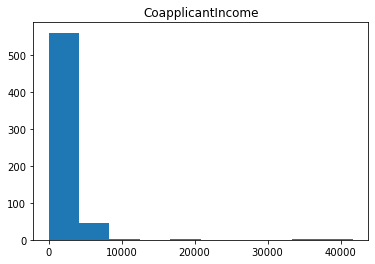

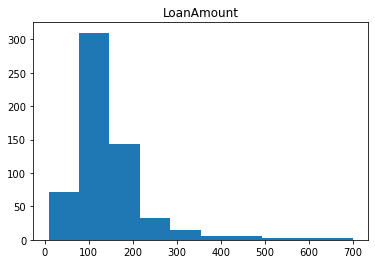

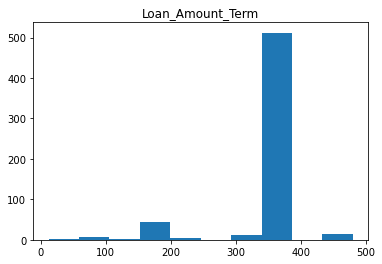

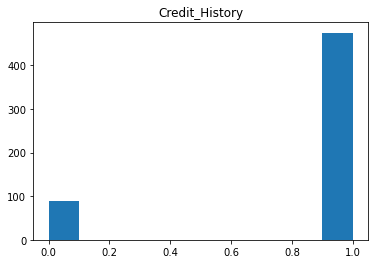

In [11]:
for i in df_train_num.columns:
    plt.hist(df_train_num[i])
    plt.title(i)
    plt.show()

                   ApplicantIncome  CoapplicantIncome  LoanAmount  \
ApplicantIncome           1.000000          -0.116605    0.570909   
CoapplicantIncome        -0.116605           1.000000    0.188619   
LoanAmount                0.570909           0.188619    1.000000   
Loan_Amount_Term         -0.045306          -0.059878    0.039447   
Credit_History           -0.014715          -0.002056   -0.008433   

                   Loan_Amount_Term  Credit_History  
ApplicantIncome           -0.045306       -0.014715  
CoapplicantIncome         -0.059878       -0.002056  
LoanAmount                 0.039447       -0.008433  
Loan_Amount_Term           1.000000        0.001470  
Credit_History             0.001470        1.000000  


<AxesSubplot:>

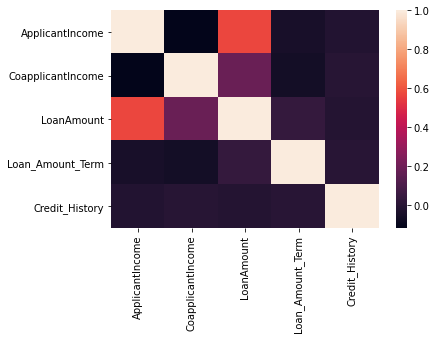

In [12]:
print(df_train_num.corr())
sns.heatmap(df_train_num.corr())

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


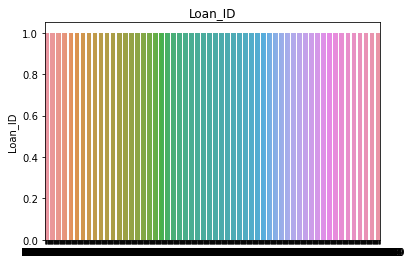

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


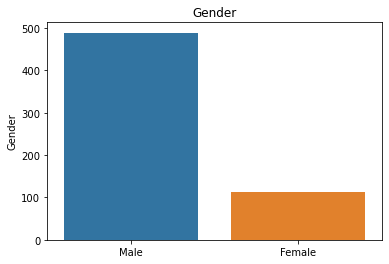

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


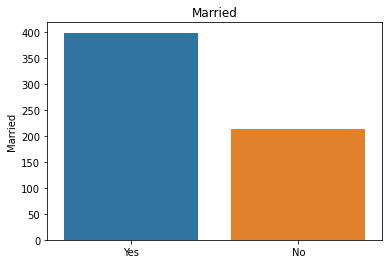

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


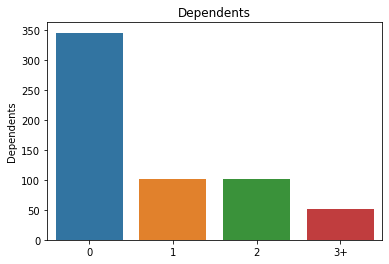

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


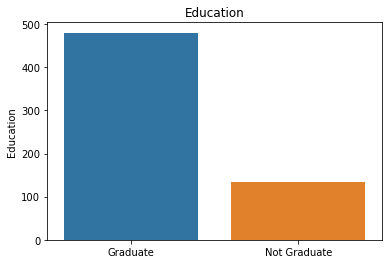

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


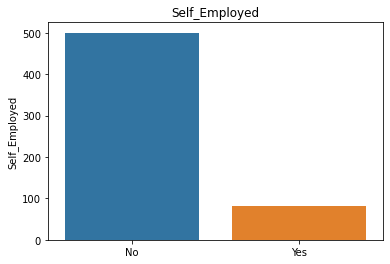

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


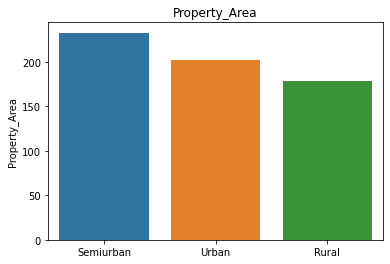

E:\Anaconda_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


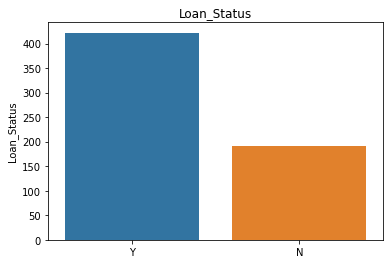

In [13]:
for i in df_train_cat.columns:
    sns.barplot(df_train_cat[i].value_counts().index, df_train_cat[i].value_counts()).set_title(i)
    plt.show()

In [14]:
pd.pivot_table(data_train, index ="Loan_Status", values = tr_num)

,ApplicantIncome,CoapplicantIncome,Credit_History,LoanAmount,Loan_Amount_Term
Loan_Status,,,,,
N,5446.078125,1877.807292,0.541899,151.220994,344.064516
Y,5384.068720,1504.516398,0.981818,144.294404,341.072464


In [15]:
data_train.isnull().sum(axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [16]:
data_train.dropna(subset=["Married"], inplace=True)
data_train = data_train.fillna(data_train.median())
data_train.isnull().sum(axis=0)
data_train.fillna(data_train.select_dtypes(include='object').mode().iloc[0], inplace=True)


In [17]:
data_test.isnull().sum(axis=0)

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [18]:
data_test.dropna(subset=["Gender","Loan_Amount_Term"], inplace=True)
data_test = data_test.fillna(data_test.median())
data_test.fillna(data_test.select_dtypes(include='object').mode().iloc[0], inplace=True)


In [19]:
data_test.isnull().sum(axis=0)

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [20]:

data_train.isnull().sum(axis=0)



Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [21]:
X_train = data_train.drop(["Loan_ID", "Loan_Status"], axis = 1)
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,127.5,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [22]:
X_test = data_test.drop(["Loan_ID"], axis = 1)
X_test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban
4,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [23]:
X_tst_cat = ["Gender", "Married", "Dependents", "Education","Self_Employed", "Property_Area"]

In [24]:
y_train = data_train["Loan_Status"]

In [25]:
X_tr_cat = ["Gender", "Married", "Dependents","Education", "Self_Employed", "Property_Area"]

In [26]:
X_train_dumm = pd.get_dummies(X_train, columns = X_tr_cat)
X_train_dumm.head()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,127.5,360.0,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,4583,1508.0,128.0,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
2,3000,0.0,66.0,360.0,1.0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1
3,2583,2358.0,120.0,360.0,1.0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,6000,0.0,141.0,360.0,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1


In [27]:
X_test_dumm = pd.get_dummies(X_test, columns = X_tst_cat)
X_test_dumm.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5720,0,110.0,360.0,1.0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1
1,3076,1500,126.0,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
2,5000,1800,208.0,360.0,1.0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1
3,2340,2546,100.0,360.0,1.0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1
4,3276,0,78.0,360.0,1.0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1


In [28]:
X_train_dumm = X_train_dumm.drop(["Gender_Female", "Married_No", "Education_Not Graduate", "Dependents_3+","Self_Employed_No", "Property_Area_Rural"], axis=1)
X_train_dumm.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,127.5,360.0,1.0,1,0,1,0,0,1,0,0,1
1,4583,1508.0,128.0,360.0,1.0,1,1,0,1,0,1,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,1,0,0,1,1,0,1
3,2583,2358.0,120.0,360.0,1.0,1,1,1,0,0,0,0,0,1
4,6000,0.0,141.0,360.0,1.0,1,0,1,0,0,1,0,0,1


In [29]:
X_test_dumm = X_test_dumm.drop(["Gender_Female", "Married_No", "Education_Not Graduate", "Dependents_3+","Self_Employed_No", "Property_Area_Rural"], axis=1)
X_test_dumm.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5720,0,110.0,360.0,1.0,1,1,1,0,0,1,0,0,1
1,3076,1500,126.0,360.0,1.0,1,1,0,1,0,1,0,0,1
2,5000,1800,208.0,360.0,1.0,1,1,0,0,1,1,0,0,1
3,2340,2546,100.0,360.0,1.0,1,1,0,0,1,1,0,0,1
4,3276,0,78.0,360.0,1.0,1,0,1,0,0,0,0,0,1


In [30]:
print(type(X_train_dumm))

<class 'pandas.core.frame.DataFrame'>


In [31]:
scaled_features = X_train_dumm.copy()
col_names = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names]= features
scaled_features.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0.073496,-0.555746,-0.216293,0.275516,1.0,1,0,1,0,0,1,0,0,1
1,-0.133510,-0.040955,-0.210358,0.275516,1.0,1,1,0,1,0,1,0,0,0
2,-0.392350,-0.555746,-0.946333,0.275516,1.0,1,1,1,0,0,1,1,0,1
3,-0.460534,0.249212,-0.305322,0.275516,1.0,1,1,1,0,0,0,0,0,1
4,0.098187,-0.555746,-0.056040,0.275516,1.0,1,0,1,0,0,1,0,0,1


In [32]:
scald_features = X_test_dumm.copy()
col_names = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
fea = scald_features[col_names]
scalery = StandardScaler().fit(fea.values)
fea = scaler.transform(fea.values)

scald_features[col_names]= fea
scald_features.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0.052403,-0.555746,-0.424028,0.275516,1.0,1,1,1,0,0,1,0,0,1
1,-0.379923,-0.043686,-0.234099,0.275516,1.0,1,1,0,1,0,1,0,0,1
2,-0.065325,0.058726,0.739288,0.275516,1.0,1,1,0,0,1,1,0,0,1
3,-0.500268,0.313390,-0.542734,0.275516,1.0,1,1,0,0,1,1,0,0,1
4,-0.347220,-0.555746,-0.803886,0.275516,1.0,1,0,1,0,0,0,0,0,1


In [33]:
X_test_final = scald_features
X_test_final.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0.052403,-0.555746,-0.424028,0.275516,1.0,1,1,1,0,0,1,0,0,1
1,-0.379923,-0.043686,-0.234099,0.275516,1.0,1,1,0,1,0,1,0,0,1
2,-0.065325,0.058726,0.739288,0.275516,1.0,1,1,0,0,1,1,0,0,1
3,-0.500268,0.313390,-0.542734,0.275516,1.0,1,1,0,0,1,1,0,0,1
4,-0.347220,-0.555746,-0.803886,0.275516,1.0,1,0,1,0,0,0,0,0,1


In [34]:
X_train_final = scaled_features
X_train_final.head()
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 0 to 613
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          611 non-null    float64
 1   CoapplicantIncome        611 non-null    float64
 2   LoanAmount               611 non-null    float64
 3   Loan_Amount_Term         611 non-null    float64
 4   Credit_History           611 non-null    float64
 5   Gender_Male              611 non-null    uint8  
 6   Married_Yes              611 non-null    uint8  
 7   Dependents_0             611 non-null    uint8  
 8   Dependents_1             611 non-null    uint8  
 9   Dependents_2             611 non-null    uint8  
 10  Education_Graduate       611 non-null    uint8  
 11  Self_Employed_Yes        611 non-null    uint8  
 12  Property_Area_Semiurban  611 non-null    uint8  
 13  Property_Area_Urban      611 non-null    uint8  
dtypes: float64(5), uint8(9)
me

In [35]:
le = LabelEncoder()
y_train_final = le.fit_transform(y_train)

In [36]:
classfr = LogisticRegression(random_state = 0)
model = classfr.fit(X_train_final, y_train_final)

print("Training accuracy with LogisticRegression is: ", model.score(X_train_final, y_train_final))



Training accuracy with LogisticRegression is:  0.8117839607201309


In [37]:
y_pred = model.predict(X_test_final)
y_pred_final = le.inverse_transform(y_pred)


In [38]:
Loan_ID = data_test["Loan_ID"]

In [39]:
loan_prediction = pd.DataFrame.from_dict({"Loan_ID": Loan_ID, "Loan approved(Y/N)": y_pred_final})


In [40]:
loan_prediction.to_csv("loan_apprv_pred.csv", index = False)

In [41]:
xgbclass = XGBClassifier()
model_2 = xgbclass.fit(X_train_final, y_train_final)

print("Training accuracy with XGBClassifier is: ", model_2.score(X_train_final, y_train_final))

E:\Anaconda_main\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy with XGBClassifier is:  1.0


In [42]:
y_pred_xgb = model_2.predict(X_test_final)
y_xgb_final = le.inverse_transform(y_pred_xgb)

In [43]:
loan_approv_prediction = pd.DataFrame.from_dict({"Loan_ID": Loan_ID, "Loan_Status": y_xgb_final})


In [45]:
loan_approv_prediction.to_csv("loan_apprv_pred_xgb(analytics comp).csv", index = False)